In [67]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, f1_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import catboost as cb
import lightgbm as lgb
import optuna
from imblearn.under_sampling import RandomUnderSampler
import optuna.visualization as vis
import numpy as np
import warnings

warnings.filterwarnings("ignore")
import sys
print(sys.executable)


c:\Users\emanu\Analysis-on-Churn-Banking-Modeling-Dataset\.venv\Scripts\python.exe


In [68]:
df = pd.read_csv(r"Churn_Banking_Modeling.csv")
df = df.drop('Id_Cliente',axis=1)
df.head()

,Flag_Richiesta_Estinzione_cc,Imp_Valore_del_Cliente,Flag_Apertura_Conto_Online,Flag_Possesso_piu_Conti,Eta,Provincia_Domicilio,Provincia_Residenza,Anno_Apertura_primo_Conto,Professione,Imp_Reddito,...,Imp_Liquidit�_Attuale,Imp_Gestito_attuale,Imp_Amministrato_attuale,Imp_Liquidit�_Attuale_6m,Imp_Gestito_attuale_6m,Imp_Amministrato_attuale_6m,Flag_Trasferimento_Titoli_Out,Flag_Rifiuto_Carte,Flag_Rifiuto_Prestiti,Flag_Disattivazione_RID
0,no,65.03,0,0,38.0,BO,BO,2004.0,Impiegato,Medio (tra 1500 e 1800),...,1634.57,2978.40,2980.92,1550.44,2853.2,2853.22,0,0,0,0
1,no,138.88,0,0,45.0,SA,SA,2000.0,Impiegato,Alto (tra 1800 e 2500),...,11918.26,NaN,34916.15,26122.17,NaN,22053.82,0,0,0,0
2,no,546.54,0,0,61.0,VT,VT,2005.0,Altro/Nessuno,Alto (tra 1800 e 2500),...,2671.95,NaN,232776.62,16545.25,NaN,216304.33,1,0,0,0
3,no,68.69,0,0,33.0,MI,MI,2010.0,Impiegato,Basso (tra 1200 e 1500),...,19211.31,15013.53,15017.53,12500.00,NaN,NaN,0,0,0,0
4,no,2417.05,0,0,36.0,MI,MI,2001.0,Quadro,NaN,...,1526.38,NaN,NaN,1427.70,NaN,21514.60,0,0,0,0


In [69]:
X = df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y = df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  # Converte in 0 e 1
XX = pd.get_dummies(X)


In [70]:
def clean_feature_names(df):
    df.columns = [col.replace(' ', '_').replace('[', '').replace(']', '').replace('<', '') for col in df.columns]
    return df

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
X_train = pd.get_dummies(X)

missing_columns_train = set(XX.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(XX.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[XX.columns]
X_test = X_test[XX.columns]

rus = RandomUnderSampler(sampling_strategy=0.03)  # Proporzione è sempre 1:36, ho ipotizzato che il dataset su cui andremo a fare le nostre prediction sia delle stesse dimensioni di questo, 360k. Dovendo andare a prendere i top 10k clienti ho cercato di mantenere le stesse proporzioni
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
X_train_res = pd.get_dummies(X_train_res)
X_test = pd.get_dummies(X_test)
X_train_res = clean_feature_names(X_train_res)
X_test = clean_feature_names(X_test)

X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)


LightGBM : Tuning hyperparametri

In [72]:
def objective(trial):
    # Assuming X and y are your features and labels respectively
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
    XX = pd.get_dummies(pd.concat([X_train, X_test], sort=False))
    X_train, X_test = XX.loc[X_train.index], XX.loc[X_test.index]

    X_train = clean_feature_names(X_train)
    X_test = clean_feature_names(X_test)

    X_train, X_test = X_train.align(X_test, join='inner', axis=1)

    scale_pos_weight = len(y[y == 0]) / len(y[y == 1])

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'num_leaves': trial.suggest_int('num_leaves', 20, 40),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50),
        'subsample': trial.suggest_float('subsample', 0.8, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'random_state': 42,
        'force_col_wise': True,
        'verbosity': -1
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    top_k_scores = []

    for train_index, val_index in kf.split(X_train, y_train):
        X_fold_train, X_fold_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_fold_train, y_fold_val = y_train.iloc[train_index], y_train.iloc[val_index]

        model = lgb.LGBMClassifier(**params)
        model.fit(X_fold_train, y_fold_train)

        # Evaluate top K precision
        probabilities = model.predict_proba(X_fold_val)[:, 1]
        results_df = pd.DataFrame({
            'y_val': y_fold_val,
            'y_pred_proba': probabilities
        })
        results_df_sorted = results_df.sort_values(by='y_pred_proba', ascending=False)
        top_10000_si = results_df_sorted.head(10000)
        y_true_top_k = top_10000_si['y_val']
        y_pred_top_k = np.ones(10000)  # Predicting all selected as positive
        top_k_precision = precision_score(y_true_top_k, y_pred_top_k)
        top_k_scores.append(top_k_precision)

    return np.mean(top_k_scores)

sampler = optuna.samplers.TPESampler(seed=42)  
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_top_k_precision = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Top K Precision Score:", best_top_k_precision)


[I 2024-04-21 18:40:01,453] A new study created in memory with name: no-name-9aff73b1-082e-43bb-a931-1c1c481b6a75


[W 2024-04-21 18:40:08,127] Trial 0 failed with parameters: {'n_estimators': 175, 'learning_rate': 0.1540359659501924, 'max_depth': 13, 'num_leaves': 32, 'min_child_samples': 16, 'subsample': 0.8311989040672406, 'subsample_freq': 0, 'colsample_bytree': 0.9464704583099741, 'reg_alpha': 0.6011150117432088, 'reg_lambda': 0.7080725777960455, 'max_bin': 202} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\emanu\Analysis-on-Churn-Banking-Modeling-Dataset\.venv\Lib\site-packages\optuna\study\_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\emanu\AppData\Local\Temp\ipykernel_30220\3099806693.py", line 39, in objective
    model.fit(X_fold_train, y_fold_train)
  File "c:\Users\emanu\Analysis-on-Churn-Banking-Modeling-Dataset\.venv\Lib\site-packages\lightgbm\sklearn.py", line 1187, in fit
    super().fit(
  File "c:\Users\emanu\Analysis-on-Churn-Banking-Modeling-Dat

KeyboardInterrupt: 

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10) #cambiamo lo split per vedere se i nostri dati overfittano
X_train = pd.get_dummies(X_train) 
X_test = pd.get_dummies(X_test)

missing_columns_train = set(X_train_res.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(X_train_res.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[X_train_res.columns]
X_test = X_test[X_train_res.columns]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)


In [74]:
'''
Best Hyperparameters: {'n_estimators': 195, 'learning_rate': 0.0689356536665432, 'max_depth': 13, 'num_leaves': 1946, 'min_child_samples': 37, 'subsample': 0.8841796423370363, 'subsample_freq': 0, 'colsample_bytree': 0.783386192594209, 'reg_alpha': 0.7592044537020304, 'reg_lambda': 0.538402350448647, 'max_bin': 269}
Best ROC AUC Score: 0.9918504426589758
'''
best_params = {
    'n_estimators': 189,
    'learning_rate': 0.004854645028903313,
    'max_depth': 11,
    'num_leaves': 531,
    'min_child_samples': 38,
    'subsample': 0.9737339473780564,
    'subsample_freq': 4,
    'colsample_bytree': 0.7440800077902495,
    'reg_alpha': 0.24014298958881808,
    'reg_lambda': 0.3476481153310436,
    'max_bin': 288,
    'force_col_wise': True,
    'verbosity': -1
}

best_lgb_classifier = lgb.LGBMClassifier(**best_params)
best_lgb_classifier.fit(X_train, y_train)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

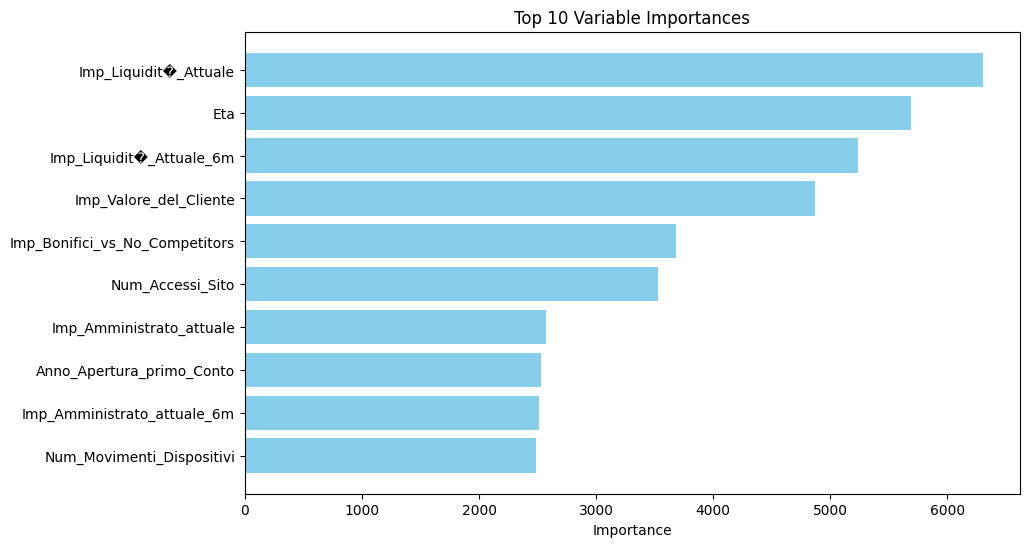

In [44]:
import matplotlib.pyplot as plt

# Get feature importances
importance = best_lgb_classifier.feature_importances_

# Summarize feature importances
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()


In [120]:
best_lgb_classifier

LGBMClassifier(colsample_bytree=0.6518355641936273, force_col_wise=True,
               learning_rate=0.045336423535558106, max_bin=280, max_depth=8,
               min_child_samples=50, n_estimators=264, num_leaves=72,
               random_state=42, reg_alpha=0.6759647727667966,
               reg_lambda=0.9300125049175274, subsample=0.9563930027208176,
               subsample_freq=1, verbosity=-1)

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=17) #cambiamo lo split per vedere se i nostri dati overfittano
X_train = pd.get_dummies(X_train) 
X_test = pd.get_dummies(X_test)

missing_columns_train = set(X_train_res.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(X_train_res.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[X_train_res.columns]
X_test = X_test[X_train_res.columns]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)


In [46]:
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
5785         1      0.578182
6664         1      0.437183
13906        1      0.415639
27061        1      0.408633
47013        1      0.398823
...        ...           ...
157504       0      0.005997
199877       0      0.005997
99554        0      0.005997
246641       0      0.005997
178101       0      0.005996

[10000 rows x 2 columns]


In [47]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 389
Numero di 'SI: nel nostro test set 410


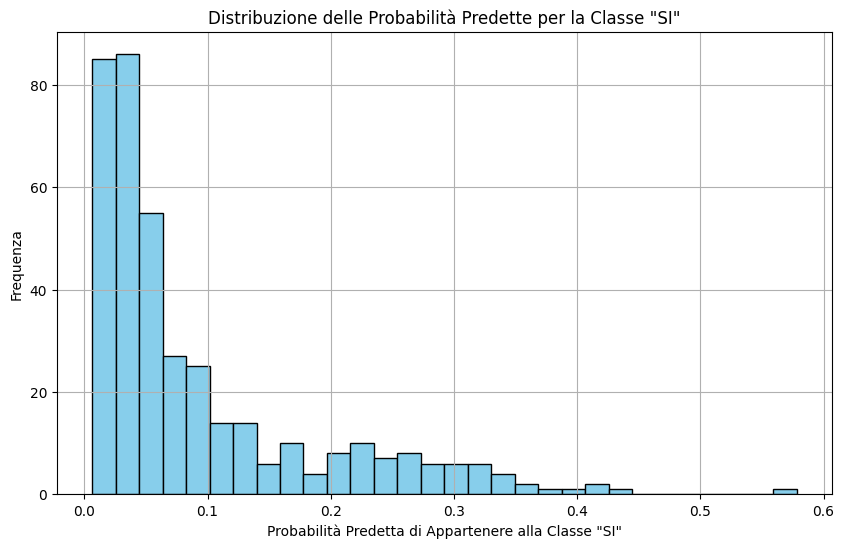

In [48]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

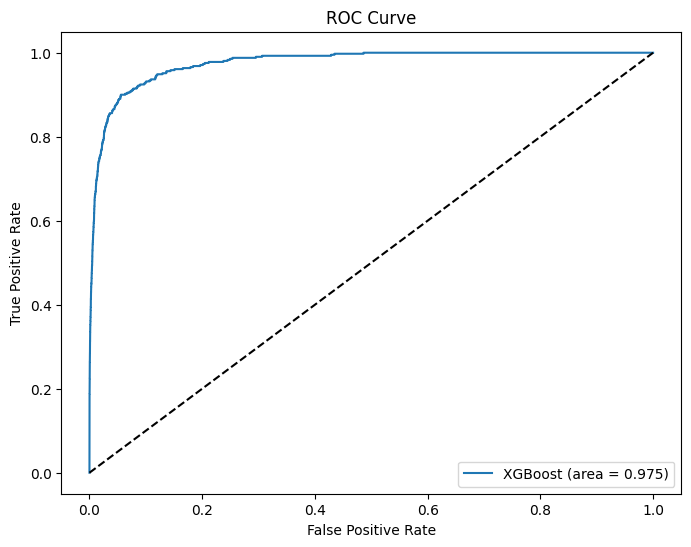

In [49]:
fpr, tpr, thresholds = roc_curve(y_test, lgbm_predictions)
auc = roc_auc_score(y_test, lgbm_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

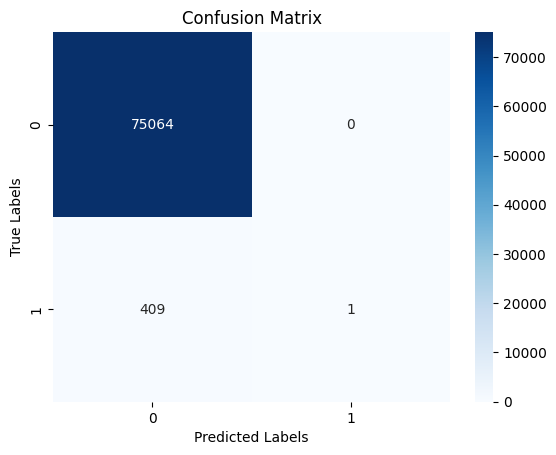

In [50]:
y_pred = best_lgb_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


XGBoost: Tuning hyperparametri

In [121]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 2)
    missing_columns_train = set(XX.columns) - set(X_train.columns)
    for col in missing_columns_train:
        X_train[col] = 0

    missing_columns_test = set(XX.columns) - set(X_test.columns)
    for col in missing_columns_test:
        X_test[col] = 0

    X_train = X_train[XX.columns]
    X_test = X_test[XX.columns]
        
    rus = RandomUnderSampler(sampling_strategy=0.03)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
    y_train_res.reset_index(drop=True, inplace=True)  
    X_train_res = pd.get_dummies(X_train_res)
    X_test = pd.get_dummies(X_test)
    X_train_res = clean_feature_names(X_train_res)
    X_test = clean_feature_names(X_test)

    X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.5),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10),
        'verbosity': 0
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True)
    scores = []
    for train_index, val_index in kf.split(X_train_res, y_train_res):
        X_fold_train, X_fold_val = X_train_res.iloc[train_index], X_train_res.iloc[val_index]
        y_fold_train, y_fold_val = y_train_res[train_index], y_train_res[val_index]
        
        model = xgb.XGBClassifier(**params)
        model.fit(X_fold_train, y_fold_train, eval_metric="auc")
        y_fold_pred = model.predict_proba(X_fold_val)[:, 1]
        score = roc_auc_score(y_fold_val, y_fold_pred)
        scores.append(score)
    
    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_roc_auc = study.best_value

print("Best Hyperparameters:", best_params)
print("Best ROC AUC Score:", best_roc_auc)

history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()

'\ndef objective(trial):\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)\n        \n    sampling_strategy = trial.suggest_float(\'sampling_strategy\', 0.1, 1.0)\n    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)\n    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)\n    y_train_res.reset_index(drop=True, inplace=True)\n    X_train_res = pd.get_dummies(X_train_res)\n    X_test = pd.get_dummies(X_test)\n\n    X_train_res = clean_feature_names(X_train_res)\n    X_test = clean_feature_names(X_test)\n\n    X_train_res, X_test = X_train_res.align(X_test, join=\'inner\', axis=1)\n\n    params = {\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 100, 1000),\n        \'learning_rate\': trial.suggest_loguniform(\'learning_rate\', 0.01, 0.5),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 3, 10),\n        \'min_child_weight\': trial.suggest_int(\'min_child_weight\', 1, 

In [98]:
'''
Best Hyperparameters: {'sampling_strategy': 0.1251773261463979, 'n_estimators': 911, 'learning_rate': 0.05255473835317336, 'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.6405856996548562, 'colsample_bytree': 0.9964394946899515, 'gamma': 1.2121534098151838, 'reg_alpha': 1.1808576291047457, 'reg_lambda': 2.7143652609430546}
Best ROC AUC Score: 0.9910838203489621
'''
xgb_params = {
    'n_estimators': 911,
    'learning_rate': 0.05255473835317336,
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 0.6405856996548562,
    'colsample_bytree': 0.9964394946899515,
    'gamma': 1.2121534098151838,
    'reg_alpha': 1.1808576291047457,
    'reg_lambda': 2.7143652609430546,
    'random_state': 42  
}

best_xgb_classifier = xgb.XGBClassifier(**xgb_params)

best_xgb_classifier.fit(X_train, y_train)
xgb_predictions = best_xgb_classifier.predict_proba(X_test)[:, 1]

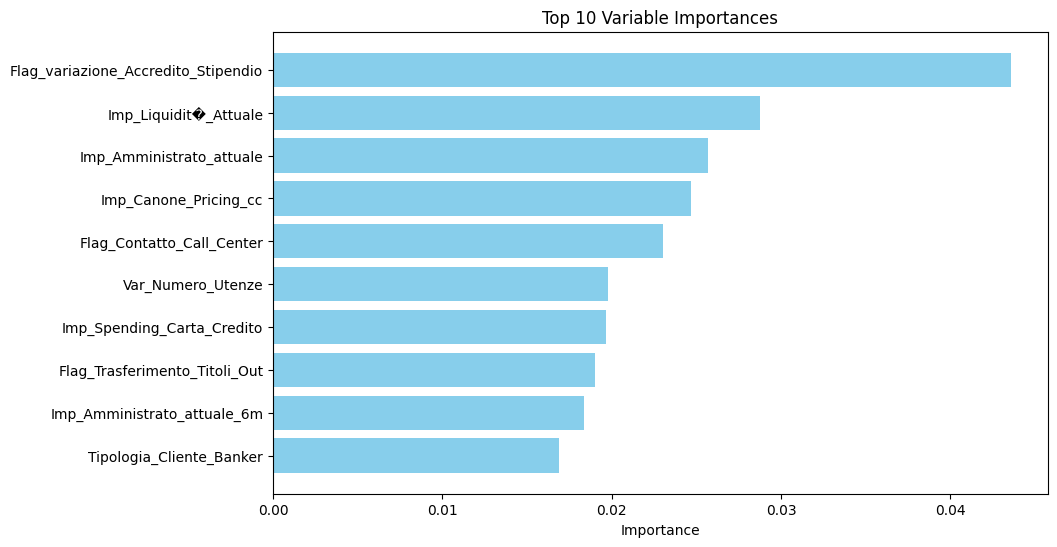

In [99]:
import matplotlib.pyplot as plt

# Get feature importances
importance = best_xgb_classifier.feature_importances_

# Summarize feature importances
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()


In [123]:
best_xgb_classifier

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9964394946899515, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=1.2121534098151838,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05255473835317336,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=911, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [100]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37) #cambiamo lo split per vedere se i nostri dati overfittano
X_train = pd.get_dummies(X_train) 
X_test = pd.get_dummies(X_test)

missing_columns_train = set(X_train_res.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(X_train_res.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[X_train_res.columns]
X_test = X_test[X_train_res.columns]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

#best_lgb_classifier.fit(X_train, y_train)
xgb_predictions = best_xgb_classifier.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': xgb_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
17390        1      0.985261
6844         1      0.949116
58339        1      0.849980
52799        1      0.832256
17391        1      0.803931
...        ...           ...
171994       0      0.007002
285806       0      0.007001
229849       0      0.007000
92093        0      0.006999
16976        0      0.006998

[10000 rows x 2 columns]


In [101]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 322
Numero di 'SI: nel nostro test set 376


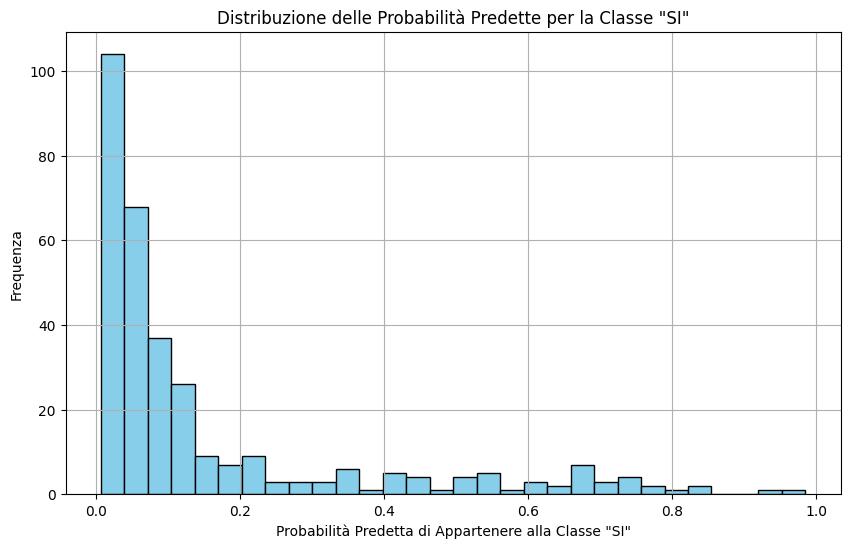

In [102]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

Catboost: Tuning hyperparametri

In [124]:
def objective(trial):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        
    sampling_strategy = trial.suggest_float('sampling_strategy', 0.1, 1.0)
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)
    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
    y_train_res.reset_index(drop=True, inplace=True)
    X_train_res = pd.get_dummies(X_train_res)
    X_test = pd.get_dummies(X_test)

    X_train_res = clean_feature_names(X_train_res)
    X_test = clean_feature_names(X_test)

    X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)

    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'max_depth': trial.suggest_int('max_depth', 5, 15),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Depthwise', 'Lossguide']),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 1, 50),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations', 1, 10),
        'leaf_estimation_method': trial.suggest_categorical('leaf_estimation_method', ['Newton', 'Gradient']),
        'random_state': 42,
        'verbose': False
    }

    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    scores = []
    for train_index, val_index in kf.split(X_train_res, y_train_res):
        X_fold_train, X_fold_val = X_train_res.iloc[train_index], X_train_res.iloc[val_index]
        y_fold_train, y_fold_val = y_train_res[train_index], y_train_res[val_index]
        
        model = cb.CatBoostClassifier(**params)
        model.fit(X_fold_train, y_fold_train)
        y_fold_pred = model.predict_proba(X_fold_val)[:, 1]
        score = roc_auc_score(y_fold_val, y_fold_pred)
        scores.append(score)
    
    return np.mean(scores)

sampler = optuna.samplers.TPESampler(seed=42)
study = optuna.create_study(direction='maximize', sampler=sampler)
study.optimize(objective, n_trials=50)

best_params = study.best_params
best_roc_auc = study.best_value

print("Best Hyperparameters:", best_params)
print("Best ROC AUC Score:", best_roc_auc)

history_plot = vis.plot_optimization_history(study)
history_plot.show()

importance_plot = vis.plot_param_importances(study)
importance_plot.show()

slice_plot = vis.plot_slice(study)
slice_plot.show()

'\ndef objective(trial):\n    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)\n        \n    sampling_strategy = trial.suggest_float(\'sampling_strategy\', 0.1, 1.0)\n    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=42)\n    X_train_res, y_train_res = rus.fit_resample(X_train, y_train)\n    y_train_res.reset_index(drop=True, inplace=True)\n    X_train_res = pd.get_dummies(X_train_res)\n    X_test = pd.get_dummies(X_test)\n\n    X_train_res = clean_feature_names(X_train_res)\n    X_test = clean_feature_names(X_test)\n\n    X_train_res, X_test = X_train_res.align(X_test, join=\'inner\', axis=1)\n\n    params = {\n        \'n_estimators\': trial.suggest_int(\'n_estimators\', 100, 300),\n        \'learning_rate\': trial.suggest_float(\'learning_rate\', 0.01, 0.2, log=True),\n        \'max_depth\': trial.suggest_int(\'max_depth\', 5, 15),\n        \'l2_leaf_reg\': trial.suggest_float(\'l2_leaf_reg\', 1e-3, 1

In [103]:
'''
Best Hyperparameters: {'sampling_strategy': 0.24371396656270275, 'n_estimators': 233, 'learning_rate': 0.1475404432012003, 'max_depth': 10, 'l2_leaf_reg': 1.66818163795537, 'border_count': 234, 'grow_policy': 'Depthwise', 'min_data_in_leaf': 40, 'leaf_estimation_iterations': 2, 'leaf_estimation_method': 'Newton'}
Best ROC AUC Score: 0.991390354317063
'''
catboost_params = {
    'n_estimators': 233,
    'learning_rate': 0.1475404432012003,
    'max_depth': 10,
    'l2_leaf_reg': 1.66818163795537,
    'border_count': 234,
    'grow_policy': 'Depthwise',
    'min_data_in_leaf': 40,
    'leaf_estimation_iterations': 2,
    'leaf_estimation_method': 'Newton',
    'random_state': 42  
}

best_catboost_classifier = cb.CatBoostClassifier(**catboost_params)

best_catboost_classifier.fit(X_train, y_train)
catboost_predictions = best_catboost_classifier.predict_proba(X_test)[:, 1]


0:	learn: 0.4951605	total: 177ms	remaining: 41s
1:	learn: 0.3614353	total: 324ms	remaining: 37.4s
2:	learn: 0.2683390	total: 492ms	remaining: 37.7s
3:	learn: 0.2021586	total: 625ms	remaining: 35.8s
4:	learn: 0.1548141	total: 766ms	remaining: 35s
5:	learn: 0.1206114	total: 866ms	remaining: 32.8s
6:	learn: 0.0956869	total: 978ms	remaining: 31.6s
7:	learn: 0.0772277	total: 1.12s	remaining: 31.6s
8:	learn: 0.0641609	total: 1.23s	remaining: 30.7s
9:	learn: 0.0544662	total: 1.35s	remaining: 30.2s
10:	learn: 0.0472688	total: 1.51s	remaining: 30.5s
11:	learn: 0.0420027	total: 1.62s	remaining: 29.9s
12:	learn: 0.0377377	total: 1.79s	remaining: 30.3s
13:	learn: 0.0347047	total: 1.95s	remaining: 30.5s
14:	learn: 0.0322256	total: 2.11s	remaining: 30.6s
15:	learn: 0.0304603	total: 2.23s	remaining: 30.2s
16:	learn: 0.0291383	total: 2.4s	remaining: 30.4s
17:	learn: 0.0279045	total: 2.57s	remaining: 30.7s
18:	learn: 0.0270042	total: 2.74s	remaining: 30.9s
19:	learn: 0.0262266	total: 2.92s	remaining: 3

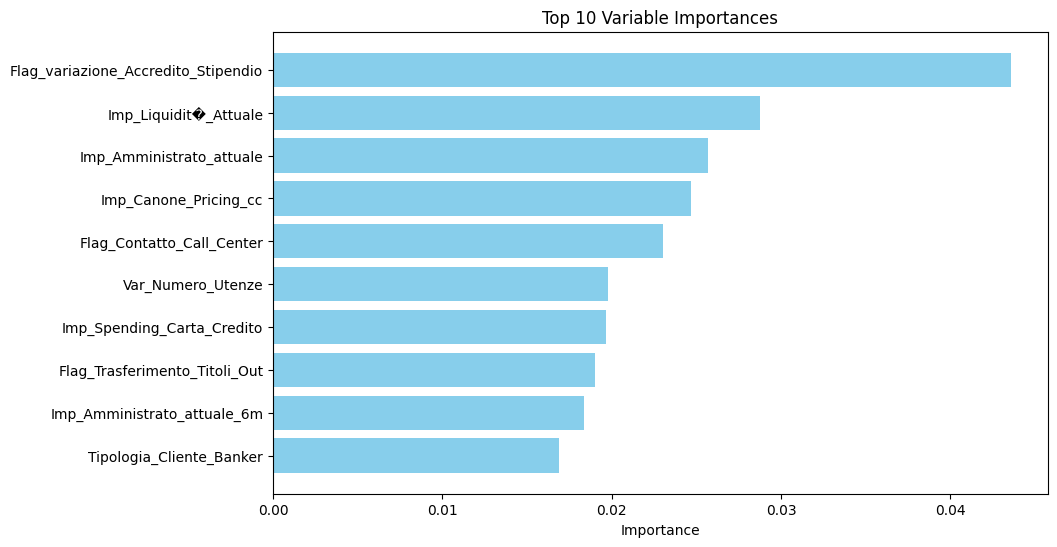

In [104]:
import matplotlib.pyplot as plt

# Get feature importances
importance = best_xgb_classifier.feature_importances_

# Summarize feature importances
features = X_train.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.title('Top 10 Variable Importances')
plt.gca().invert_yaxis()  # Invert y-axis to have the most important at the top
plt.show()


In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=51) #cambiamo lo split per vedere se i nostri dati overfittano
X_train = pd.get_dummies(X_train) 
X_test = pd.get_dummies(X_test)

missing_columns_train = set(X_train_res.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(X_train_res.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[X_train_res.columns]
X_test = X_test[X_train_res.columns]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

#best_lgb_classifier.fit(X_train, y_train)
catboost_predictions = best_catboost_classifier.predict_proba(X_test)[:, 1]

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': catboost_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

        y_test  y_pred_proba
16647        1      0.965177
13285        1      0.937079
32700        1      0.935102
54651        1      0.929105
62554        1      0.921305
...        ...           ...
67509        0      0.005329
199171       0      0.005328
351786       0      0.005328
145097       0      0.005327
266144       0      0.005326

[10000 rows x 2 columns]


In [106]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 368
Numero di 'SI: nel nostro test set 393


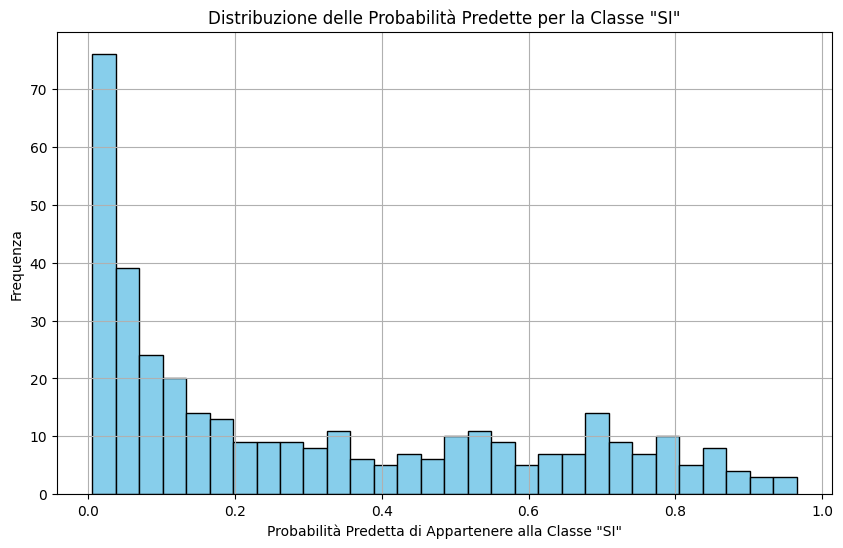

In [107]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

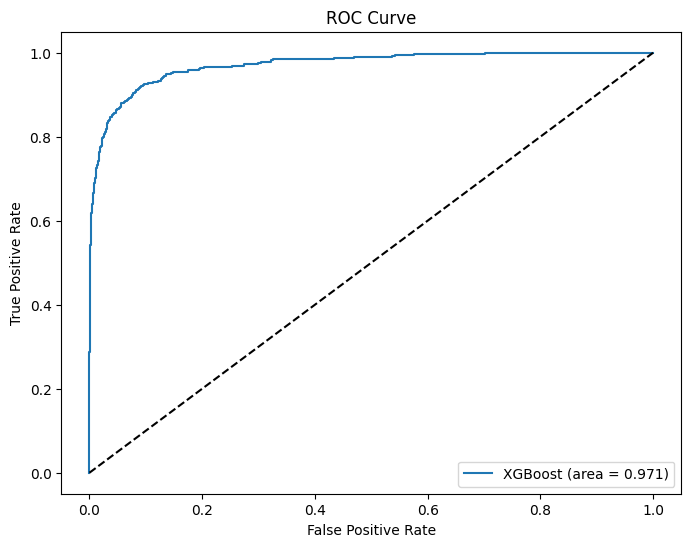

In [111]:
fpr, tpr, thresholds = roc_curve(y_test, catboost_predictions)
auc = roc_auc_score(y_test, catboost_predictions)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

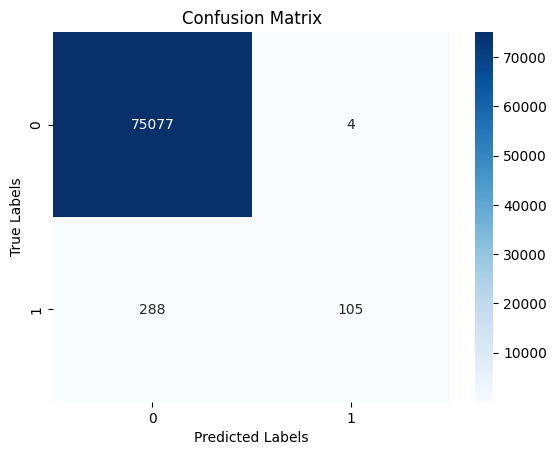

In [114]:
y_pred = best_catboost_classifier.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


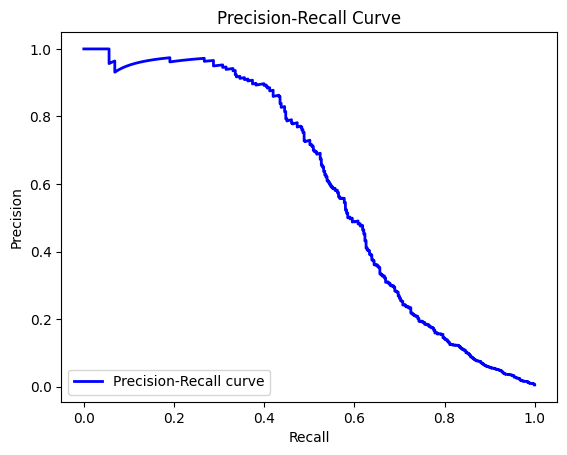

In [117]:
precision, recall, _ = precision_recall_curve(y_test, catboost_predictions)

plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()


In [119]:
train_sizes, train_scores, test_scores = learning_curve(best_catboost_classifier, X_train, y_train, cv=5, scoring='precision', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, color='r', alpha=0.1)
plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, color='g', alpha=0.1)
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
plt.xlabel('Training Size')
plt.ylabel('Score')
plt.title('Learning Curve')
plt.legend(loc="best")
plt.show()


Iterazione Metodo Brute Force per trovare i migliori pesi da dare al nostro modello per massimizzare la ROC Curve

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

missing_columns_train = set(XX.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(XX.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[XX.columns]
X_test = X_test[XX.columns]

X_train_res = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)
X_train_res = clean_feature_names(X_train_res)
X_test = clean_feature_names(X_test)

X_train_res, X_test = X_train_res.align(X_test, join='inner', axis=1)


In [62]:

def objective(trial):
    w_catboost = trial.suggest_float("w_catboost", 0.0, 0.5)
    w_xgboost = trial.suggest_float("w_xgboost", 0.0, 0.5)
    w_lgbm = trial.suggest_float("w_lgbm", 0.0, 1 - w_xgboost - w_catboost)

    weights = [w_catboost, w_xgboost, w_lgbm]

    catboost_predictions = best_catboost_classifier.predict_proba(X_test)[:, 1]
    xgb_predictions = best_xgb_classifier.predict_proba(X_test)[:, 1]
    lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]

    ensemble_predictions = (weights[0] * catboost_predictions) + (weights[1] * xgb_predictions) + (
        weights[2] * lgbm_predictions
    )

    ensemble_roc_auc = roc_auc_score(y_test, ensemble_predictions)

    return ensemble_roc_auc


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30)

best_w_catboost = study.best_params["w_catboost"]
best_w_xgboost = study.best_params["w_xgboost"]
best_w_lgbm = study.best_params["w_lgbm"]

best_weights = [best_w_catboost, best_w_xgboost, best_w_lgbm]

catboost_predictions = best_catboost_classifier.predict_proba(X_test)[:, 1]
xgb_predictions = best_xgb_classifier.predict_proba(X_test)[:, 1]
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]
best_ensemble_predictions = (best_weights[0] * catboost_predictions) + (best_weights[1] * xgb_predictions) + (best_weights[2] * lgbm_predictions)

best_ensemble_roc_auc = roc_auc_score(y_test, best_ensemble_predictions)

print("Best Weights:", best_weights)
print("Best Ensemble ROC AUC Score:", best_ensemble_roc_auc)



[I 2024-04-20 14:54:18,039] A new study created in memory with name: no-name-1223bceb-ca7c-466b-9c8a-8dcaf6f99249
[I 2024-04-20 14:54:18,926] Trial 0 finished with value: 0.9986497613320918 and parameters: {'w_catboost': 0.11690974270114662, 'w_xgboost': 0.2669602746461443, 'w_lgbm': 0.30078039713481564}. Best is trial 0 with value: 0.9986497613320918.
[I 2024-04-20 14:54:19,740] Trial 1 finished with value: 0.9976348083064066 and parameters: {'w_catboost': 0.47899013535076995, 'w_xgboost': 0.2934156023127686, 'w_lgbm': 0.04876736593492806}. Best is trial 0 with value: 0.9986497613320918.
[I 2024-04-20 14:54:20,597] Trial 2 finished with value: 0.9985867408121162 and parameters: {'w_catboost': 0.31313850367973173, 'w_xgboost': 0.15113746474158107, 'w_lgbm': 0.18251379784587426}. Best is trial 0 with value: 0.9986497613320918.
[I 2024-04-20 14:54:21,324] Trial 3 finished with value: 0.9974295797176627 and parameters: {'w_catboost': 0.2835693759577817, 'w_xgboost': 0.4541594670797268, 'w

Best Weights: [0.30299723920419197, 0.10567060691054295, 0.5157264187234696]
Best Ensemble ROC AUC Score: 0.998787507163607


In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100) #cambiamo lo split per vedere se i nostri dati overfittano
X_train = pd.get_dummies(X_train) 
X_test = pd.get_dummies(X_test)

missing_columns_train = set(X_train_res.columns) - set(X_train.columns)
for col in missing_columns_train:
    X_train[col] = 0

missing_columns_test = set(X_train_res.columns) - set(X_test.columns)
for col in missing_columns_test:
    X_test[col] = 0

X_train = X_train[X_train_res.columns]
X_test = X_test[X_train_res.columns]

X_train = clean_feature_names(X_train)
X_test = clean_feature_names(X_test)
X_train, X_test = X_train.align(X_test, join='inner', axis=1)

best_weights = [best_w_catboost, best_w_xgboost, best_w_lgbm]

catboost_predictions = best_catboost_classifier.predict_proba(X_test)[:, 1]
xgb_predictions = best_xgb_classifier.predict_proba(X_test)[:, 1]
lgbm_predictions = best_lgb_classifier.predict_proba(X_test)[:, 1]
best_ensemble_predictions = (best_weights[0] * catboost_predictions) + (best_weights[1] * xgb_predictions) + (best_weights[2] * lgbm_predictions)

results_df = pd.DataFrame({
    'y_test': y_test,
    'y_pred_proba': best_ensemble_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_10000_si = results_df_si_sorted.head(10000)
print(top_10000_si)

       y_test  y_pred_proba
5785        1      0.923868
17390       1      0.921885
6512        1      0.921189
32          1      0.920988
186         1      0.919661
...       ...           ...
40922       0      0.000337
18826       0      0.000336
65309       0      0.000336
51093       0      0.000336
47803       0      0.000336

[10000 rows x 2 columns]


In [64]:
count_si = top_10000_si[top_10000_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 404
Numero di 'SI: nel nostro test set 404


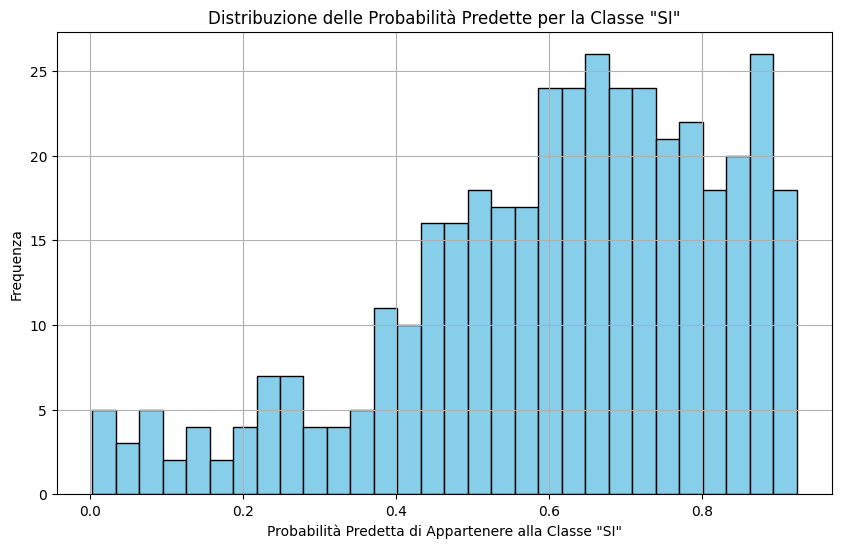

In [65]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()

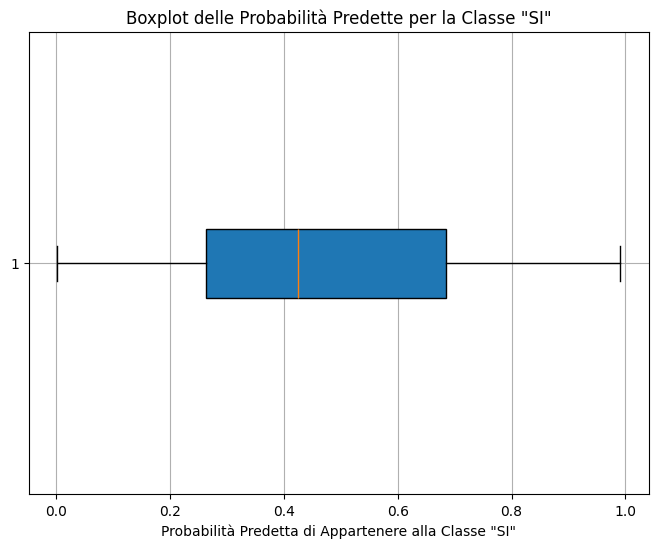

In [60]:
plt.figure(figsize=(8, 6))
plt.boxplot( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'],vert=False, patch_artist=True)
plt.title('Boxplot delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.grid(True)
plt.show()

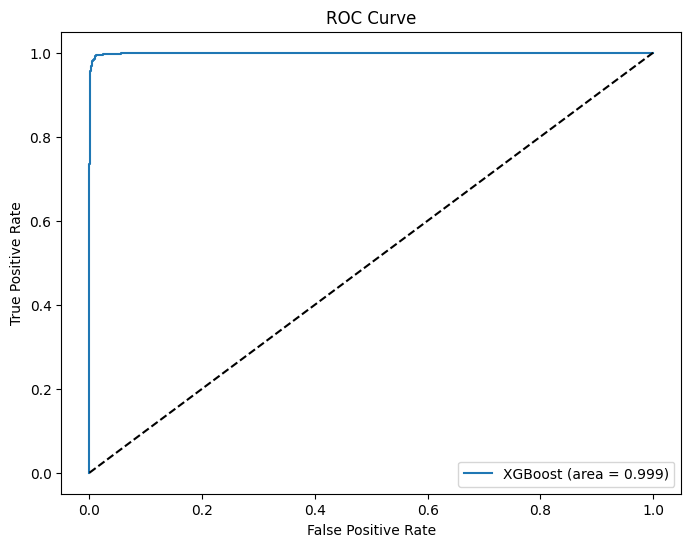

In [66]:
fpr, tpr, thresholds = roc_curve(y_test, best_ensemble_predictions)
auc = roc_auc_score(y_test, best_ensemble_predictions)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='XGBoost (area = {:.3f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')  
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [82]:
synthetic_df = pd.read_csv(r"Synthetic_dataset.csv")
synthetic_df = synthetic_df.drop('Id_Cliente',axis=1)
synthetic_df.head()

,Flag_Richiesta_Estinzione_cc,Imp_Valore_del_Cliente,Flag_Apertura_Conto_Online,Flag_Possesso_piu_Conti,Eta,Provincia_Domicilio,Provincia_Residenza,Anno_Apertura_primo_Conto,Professione,Imp_Reddito,...,Imp_Liquidit�_Attuale,Imp_Gestito_attuale,Imp_Amministrato_attuale,Imp_Liquidit�_Attuale_6m,Imp_Gestito_attuale_6m,Imp_Amministrato_attuale_6m,Flag_Trasferimento_Titoli_Out,Flag_Rifiuto_Carte,Flag_Rifiuto_Prestiti,Flag_Disattivazione_RID
0,no,16339.213230,0,0,60.0,MI,PE,2007.0,Quadro,Altissimo (>2500),...,43170.497329,159958.423376,490434.512929,84497.477627,185020.572483,393755.488857,0,0,0,0
1,no,4058.182448,0,0,53.0,RM,SR,2007.0,Altro/Nessuno,NaN,...,230.375195,4688.212534,23176.733087,451.972388,6745.740671,14859.007405,0,0,0,0
2,no,8.100362,0,0,66.0,PR,BG,2010.0,Altro/Nessuno,NaN,...,111.227723,67680.874240,27705.112655,75.487878,NaN,48509.650507,0,0,0,0
3,no,81.494180,0,0,35.0,PO,TO,2001.0,Libero professionista/Titolare di impresa,Altissimo (>2500),...,13932.364126,NaN,NaN,17261.406984,NaN,NaN,0,0,0,0
4,no,110.970051,1,0,41.0,LI,RE,2006.0,Quadro,NaN,...,633.494806,NaN,NaN,805.850494,NaN,NaN,0,0,0,0


In [83]:
X_synthetic = synthetic_df.drop('Flag_Richiesta_Estinzione_cc', axis=1)
y_synthetic = synthetic_df['Flag_Richiesta_Estinzione_cc'].map({'no': 0, 'si': 1})  # Converte in 0 e 1

In [132]:
X_train_synthetic, X_test_synthetic, y_train_synthetic, y_test_synthetic = train_test_split(X_synthetic, y_synthetic, test_size=0.2, random_state=1)

# Applying get_dummies after splitting to avoid leakage
X_train_synthetic = pd.get_dummies(X_train_synthetic)
X_test_synthetic = pd.get_dummies(X_test_synthetic)

# Clean feature names early after dummy creation
X_train_synthetic = clean_feature_names(X_train_synthetic)
X_test_synthetic = clean_feature_names(X_test_synthetic)

# Ensure all columns in XX are in both X_train and X_test
missing_columns_train = set(XX.columns) - set(X_train_synthetic.columns)
for col in missing_columns_train:
    X_train_synthetic[col] = 0  # Add missing columns to train as 0

missing_columns_test = set(XX.columns) - set(X_test_synthetic.columns)
for col in missing_columns_test:
    X_test_synthetic[col] = 0  # Add missing columns to test as 0

# Align both datasets to have the same columns in the same order
X_train_synthetic, X_test_synthetic = X_train_synthetic.align(X_test_synthetic, join='inner', axis=1)  # Using 'inner' to ensure both have exactly the same columns


X_train_res_synthetic = X_train_synthetic[XX.columns]
X_test_synthetic = X_test_synthetic[XX.columns]
print("Training features:", X_train_res_synthetic.shape)
print("Testing features:", X_test_synthetic.shape)

X_train_res_synthetic, X_test_synthetic = X_train_res_synthetic.align(X_test_synthetic, join='inner', axis=1)

Training features: (4000, 295)
Testing features: (1000, 295)


In [131]:
best_lgb_classifier.fit(X_train_res_synthetic, y_train_synthetic)
lgbm_predictions = best_lgb_classifier.predict_proba(X_test_synthetic)[:, 1]

In [127]:
results_df = pd.DataFrame({
    'y_test': y_test_synthetic,
    'y_pred_proba': lgbm_predictions

})

#selezioniamo top 10k clienti con possibilità di essere SI
results_df_si = results_df
results_df_si_sorted = results_df_si.sort_values(by='y_pred_proba', ascending=False)
top_100_si = results_df_si_sorted.head(100)
print(top_100_si)

      y_test  y_pred_proba
1721       0      0.083507
4087       0      0.067114
4405       0      0.051489
1126       0      0.041175
2645       0      0.041085
...      ...           ...
4080       0      0.009860
1579       0      0.009789
440        0      0.009643
1720       0      0.009634
1232       0      0.009622

[100 rows x 2 columns]


In [128]:
count_si = top_100_si[top_100_si['y_test'] == 1].shape[0]

print("Numero di 'SI' nei nostri 10k:", count_si)
count_ones = np.sum(y_test_synthetic == 1)

print("Numero di 'SI: nel nostro test set", count_ones)

Numero di 'SI' nei nostri 10k: 2
Numero di 'SI: nel nostro test set 10


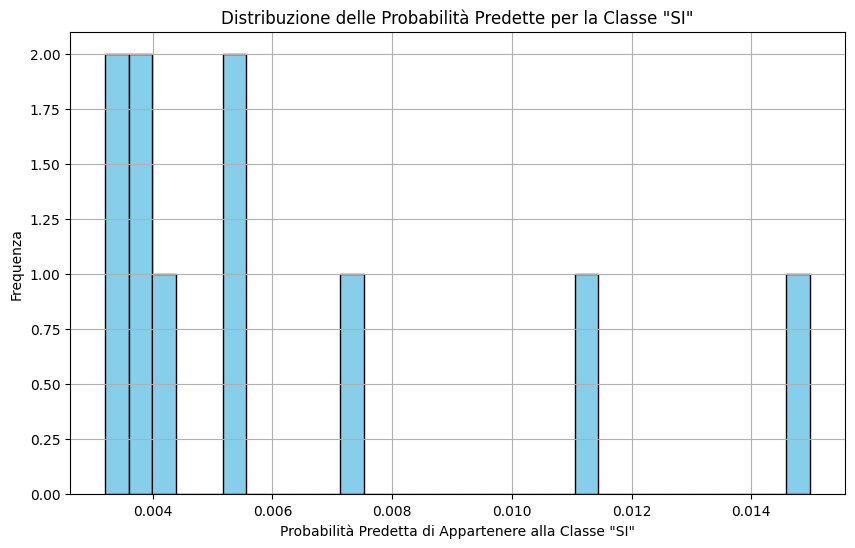

In [129]:
plt.figure(figsize=(10, 6))
plt.hist( top_10000_si[top_10000_si['y_test'] == 1]['y_pred_proba'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribuzione delle Probabilità Predette per la Classe "SI"')
plt.xlabel('Probabilità Predetta di Appartenere alla Classe "SI"')
plt.ylabel('Frequenza')
plt.grid(True)
plt.show()